In [1]:
from collections import Counter
import os
import pprint
import time

from concave_hull import concave_hull_indexes
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from scipy import spatial
from shapely.geometry import Point, Polygon

# Helper functions

In [2]:
def get_DSC(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2*intersection) / (np.sum(y_true) + np.sum(y_pred))

def get_centroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:,0])
    sum_y = np.sum(arr[:,1])
    return sum_x/length, sum_y/length

# Load external segmentations from C3RO

199: DONE
716: DONE


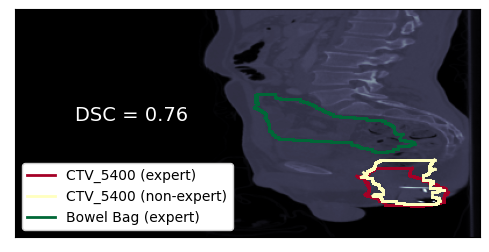

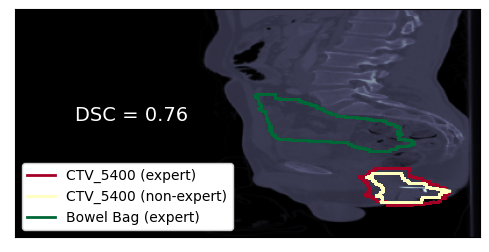

Elapsed Time: 9.199676036834717 s


In [3]:
DATA_FOLDER = 'data'
ORGAN_SITE = 'GI' #'Breast' #'GI' #'GYN' #'Sarcoma'

file_image = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'CT','NIFTI',f'Image_CT_{ORGAN_SITE}.nii.gz'))

# Uncomment these to load all images
# all_study_nums = [d for d in os.listdir(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Non-Expert')) if d not in ['Consensus']]
# all_study_nums = [str(s) for s in sorted([int(ss) for ss in all_study_nums])]
# NOTE: may have to load parts at a time due to memory concerns

# Cases from the ICCR 2024 abstract submission
# H&N: ['199','630']
# GI: ['199','716']
# GYN: ['17','182']
# Sarcoma: TBD
# Breast: TBD

all_study_results = {}
for study_num in ['199','716']: #all_study_nums:
    time_1_start = time.time()
    try:
        # TODO: this is really sloppy, define lists / dictionaries instead of different variable names
        if ORGAN_SITE == 'Breast':
            file_CTV_Ax_e = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Expert','Consensus','CTV_Ax_STAPLE.nii.gz'))
            file_Heart_e = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Expert','Consensus','Heart_STAPLE.nii.gz'))
            file_CTV_Ax_ne = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Non-Expert',study_num,'NIFTI',f'{study_num}_CTV_Ax.nii.gz'))
            file_Heart_ne = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Non-Expert',study_num,'NIFTI',f'{study_num}_Heart.nii.gz'))

            seg_data_CTV_Ax_e = file_CTV_Ax_e.get_fdata()
            seg_data_Heart_e = file_Heart_e.get_fdata()
            seg_data_CTV_Ax_ne = file_CTV_Ax_ne.get_fdata()
            seg_data_Heart_ne = file_Heart_ne.get_fdata()

            del file_CTV_Ax_e
            del file_Heart_e
            del file_CTV_Ax_ne
            del file_Heart_ne

            slices_CTV_Ax_e = set(np.where(seg_data_CTV_Ax_e != 0)[2])
            slices_Heart_e = set(np.where(seg_data_Heart_e != 0)[2])
            slices_CTV_Ax_ne = set(np.where(seg_data_CTV_Ax_ne != 0)[2])
            slices_Heart_ne = set(np.where(seg_data_Heart_ne != 0)[2])
            slice_num = int(np.median(np.array(list(slices_CTV_Ax_e & slices_Heart_e & slices_CTV_Ax_ne & slices_Heart_ne))))

            seg_data_CTV_Ax_e = seg_data_CTV_Ax_e[:,:,slice_num]
            seg_data_Heart_e = seg_data_Heart_e[:,:,slice_num]
            seg_data_CTV_Ax_ne = seg_data_CTV_Ax_ne[:,:,slice_num]
            seg_data_Heart_ne = seg_data_Heart_ne[:,:,slice_num]
            file_image_slice = file_image.get_fdata()[:,:,slice_num].T

            seg_types = [
                seg_data_CTV_Ax_e, seg_data_CTV_Ax_ne,  # target
                seg_data_Heart_e                        # OAR
            ]
            seg_type_names = [
                'CTV_e', 'CTV_ne',                      # target
                'Heart_e',                              # OAR
            ]

        elif ORGAN_SITE == 'GI':
            file_CTV_5400_e = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Expert','Consensus','CTV_5400_STAPLE.nii.gz'))
            file_Bag_Bowel_e = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Expert','Consensus','Bag_Bowel_STAPLE.nii.gz'))
            file_CTV_5400_ne = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Non-Expert',study_num,'NIFTI',f'{study_num}_CTV_5400.nii.gz'))
            file_Bag_Bowel_ne = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Non-Expert',study_num,'NIFTI',f'{study_num}_Bag_Bowel.nii.gz'))

            seg_data_CTV_5400_e = file_CTV_5400_e.get_fdata()
            seg_data_Bag_Bowel_e = file_Bag_Bowel_e.get_fdata()
            seg_data_CTV_5400_ne = file_CTV_5400_ne.get_fdata()
            seg_data_Bag_Bowel_ne = file_Bag_Bowel_ne.get_fdata()

            del file_CTV_5400_e
            del file_Bag_Bowel_e
            del file_CTV_5400_ne
            del file_Bag_Bowel_ne

            slices_CTV_5400_e = set(np.where(seg_data_CTV_5400_e != 0)[0])
            slices_Bag_Bowel_e = set(np.where(seg_data_Bag_Bowel_e != 0)[0])
            slices_CTV_5400_ne = set(np.where(seg_data_CTV_5400_ne != 0)[0])
            slices_Bag_Bowel_ne = set(np.where(seg_data_Bag_Bowel_ne != 0)[0])
            slice_num = int(np.median(np.array(list(slices_CTV_5400_e & slices_Bag_Bowel_e & slices_CTV_5400_ne & slices_Bag_Bowel_ne))))

            seg_data_CTV_5400_e = seg_data_CTV_5400_e[slice_num,:,:]
            seg_data_Bag_Bowel_e = seg_data_Bag_Bowel_e[slice_num,:,:]
            seg_data_CTV_5400_ne = seg_data_CTV_5400_ne[slice_num,:,:]
            seg_data_Bag_Bowel_ne = seg_data_Bag_Bowel_ne[slice_num,:,:]
            file_image_slice = file_image.get_fdata()[slice_num,:,:].T

            seg_types = [
                seg_data_CTV_5400_e, seg_data_CTV_5400_ne,  # target
                seg_data_Bag_Bowel_e                        # OAR
            ]
            seg_type_names = [
                'CTV_5400_e', 'CTV_5400_ne',                # target
                'Bowel Bag_e',                              # OAR
            ]

        elif ORGAN_SITE == 'GYN':
            file_GTVn_e = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Expert','Consensus','GTVn_STAPLE.nii.gz'))
            file_Bowel_Small_e = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Expert','Consensus','Bowel_Small_STAPLE.nii.gz'))
            file_GTVn_ne = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Non-Expert',study_num,'NIFTI',f'{study_num}_GTVn.nii.gz'))
            file_Bowel_Small_ne = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Non-Expert',study_num,'NIFTI',f'{study_num}_Bowel_Small.nii.gz'))

            seg_data_GTVn_e = file_GTVn_e.get_fdata()
            seg_data_Bowel_Small_e = file_Bowel_Small_e.get_fdata()
            seg_data_GTVn_ne = file_GTVn_ne.get_fdata()
            seg_data_Bowel_Small_ne = file_Bowel_Small_ne.get_fdata()

            del file_GTVn_e
            del file_Bowel_Small_e
            del file_GTVn_ne
            del file_Bowel_Small_ne

            slices_GTVn_e = set(np.where(seg_data_GTVn_e != 0)[2])
            slices_Bowel_Small_e = set(np.where(seg_data_Bowel_Small_e != 0)[2])
            slices_GTVn_ne = set(np.where(seg_data_GTVn_ne != 0)[2])
            slices_Bowel_Small_ne = set(np.where(seg_data_Bowel_Small_ne != 0)[2])
            slice_num = int(np.median(np.array(list(slices_GTVn_e & slices_Bowel_Small_e & slices_GTVn_ne & slices_Bowel_Small_ne))))

            seg_data_GTVn_e = seg_data_GTVn_e[:,:,slice_num]
            seg_data_Bowel_Small_e = seg_data_Bowel_Small_e[:,:,slice_num]
            seg_data_GTVn_ne = seg_data_GTVn_ne[:,:,slice_num]
            seg_data_Bowel_Small_ne = seg_data_Bowel_Small_ne[:,:,slice_num]
            file_image_slice = file_image.get_fdata()[:,:,slice_num].T

            seg_types = [
                seg_data_GTVn_e, seg_data_GTVn_ne,      # target
                seg_data_Bowel_Small_e                  # OAR
            ]
            seg_type_names = [
                'GTVn_e', 'GTVn_ne',                    # target
                'Small Bowel_e',                        # OAR
            ]

        elif ORGAN_SITE == 'H&N':
            file_GTVp_e = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Expert','Consensus',f'GTVp_STAPLE.nii.gz'))
            file_parotidL_e = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Expert','Consensus',f'Parotid_L_STAPLE.nii.gz'))
            file_parotidR_e = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Expert','Consensus',f'Parotid_R_STAPLE.nii.gz'))
            file_GTVp_ne = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Non-Expert',study_num,'NIFTI',f'{study_num}_GTVp.nii.gz'))
            file_parotidL_ne = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Non-Expert',study_num,'NIFTI',f'{study_num}_Parotid_L.nii.gz'))
            file_parotidR_ne = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Non-Expert',study_num,'NIFTI',f'{study_num}_Parotid_R.nii.gz'))

            seg_data_GTVp_e = file_GTVp_e.get_fdata()
            seg_data_parotidL_e = file_parotidL_e.get_fdata()
            seg_data_parotidR_e = file_parotidR_e.get_fdata()
            seg_data_GTVp_ne = file_GTVp_ne.get_fdata()
            seg_data_parotidL_ne = file_parotidL_ne.get_fdata()
            seg_data_parotidR_ne = file_parotidR_ne.get_fdata()

            del file_GTVp_e
            del file_parotidL_e
            del file_parotidR_e
            del file_GTVp_ne
            del file_parotidL_ne
            del file_parotidR_ne

            time_1_start = time.time()
            slices_GTVp_e = set(np.where(seg_data_GTVp_e != 0)[2])
            slices_parotidL_e = set(np.where(seg_data_parotidL_e != 0)[2])
            slices_parotidR_e = set(np.where(seg_data_parotidR_e != 0)[2])
            slices_GTVp_ne = set(np.where(seg_data_GTVp_ne != 0)[2])
            slices_parotidL_ne = set(np.where(seg_data_parotidL_ne != 0)[2])
            slices_parotidR_ne = set(np.where(seg_data_parotidR_ne != 0)[2])
            # slice_num = int(np.median(np.array(list(slices_GTVp_e & slices_parotidL_e & slices_parotidR_e & slices_GTVp_ne & slices_parotidL_ne & slices_parotidR_ne))))
            slice_num = 75

            seg_data_GTVp_e = np.flipud(seg_data_GTVp_e[:,:,slice_num].T).T
            seg_data_parotidL_e = np.flipud(seg_data_parotidL_e[:,:,slice_num].T).T
            seg_data_parotidR_e = np.flipud(seg_data_parotidR_e[:,:,slice_num].T).T
            seg_data_GTVp_ne = np.flipud(seg_data_GTVp_ne[:,:,slice_num].T).T
            seg_data_parotidL_ne = np.flipud(seg_data_parotidL_ne[:,:,slice_num].T).T
            seg_data_parotidR_ne = np.flipud(seg_data_parotidR_ne[:,:,slice_num].T).T
            file_image_slice = np.flipud(file_image.get_fdata()[:,:,slice_num].T)

            seg_types = [
                seg_data_GTVp_e, seg_data_GTVp_ne,          # target
                seg_data_parotidL_e, seg_data_parotidR_e    # OAR
            ]
            seg_type_names = [
                'GTVp_e', 'GTVp_ne',                        # target
                'Left Parotid_e', 'Right Parotid_e',        # OAR
            ]
            time_1_stop = time.time()

        elif ORGAN_SITE == 'Sarcoma':
            file_GTV_e = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Expert','Consensus','GTV_STAPLE.nii.gz'))
            file_Genitals_e = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Expert','Consensus','Genitals_STAPLE.nii.gz'))
            file_GTV_ne = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Non-Expert',study_num,'NIFTI',f'{study_num}_GTV.nii.gz'))
            file_Genitals_ne = nib.load(os.path.join(DATA_FOLDER,ORGAN_SITE,'Segmentations','Non-Expert',study_num,'NIFTI',f'{study_num}_Genitals.nii.gz'))

            seg_data_GTV_e = file_GTV_e.get_fdata()
            seg_data_Genitals_e = file_Genitals_e.get_fdata()
            seg_data_GTV_ne = file_GTV_ne.get_fdata()
            seg_data_Genitals_ne = file_Genitals_ne.get_fdata()

            del file_GTV_e
            del file_Genitals_e
            del file_GTV_ne
            del file_Genitals_ne

            slices_GTV_e = set(np.where(seg_data_GTV_e != 0)[2])
            slices_Genitals_e = set(np.where(seg_data_Genitals_e != 0)[2])
            slices_GTV_ne = set(np.where(seg_data_GTV_ne != 0)[2])
            slices_Genitals_ne = set(np.where(seg_data_Genitals_ne != 0)[2])
            slice_num = int(np.median(np.array(list(slices_GTV_e & slices_Genitals_e & slices_GTV_ne & slices_Genitals_ne))))

            seg_data_GTV_e = seg_data_GTV_e[:,:,slice_num]
            seg_data_Genitals_e = seg_data_Genitals_e[:,:,slice_num]
            seg_data_GTV_ne = seg_data_GTV_ne[:,:,slice_num]
            seg_data_Genitals_ne = seg_data_Genitals_ne[:,:,slice_num]
            file_image_slice = file_image.get_fdata()[:,:,slice_num].T

            seg_types = [
                seg_data_GTV_e, seg_data_GTV_ne,        # target
                seg_data_Genitals_e                     # OAR
            ]
            seg_type_names = [
                'GTV_e', 'GTV_ne',                      # target
                'Genitals_e',                           # OAR
            ]

    except FileNotFoundError:
        print(f'{study_num}: FAILED IMPORT')
        continue
    except ValueError:
        print(f'{study_num}: FAILED SHARED SLICE')
        continue
    time_1_stop = time.time()

    print(f'{study_num}: DONE')
    time_2_start = time.time()
    # Create the concave hull
    # NOTE: this is not necessary, it just makes the contour smoother if `CONCAVITY` > 1
    CONCAVITY = 1
    final_contours = {}
    for i,seg_type in enumerate(seg_types):
        area = np.array(np.where(seg_type != 0)).T
        idxes = concave_hull_indexes(area, concavity=CONCAVITY)
        # Get all the segments
        all_segs = list(zip(idxes[:-1], idxes[1:]))
        # Connect it all together
        try:
            all_segs.append((all_segs[-1][1], all_segs[0][0]))
        except IndexError:
            print(f'{study_num}, {seg_type_names[i]}, {slice_num}: FAILED INDEX')
            continue

        contour = []
        temp_contour = np.array([list(area[i]) for i in idxes])
        for ii in range(len(temp_contour)):
            contour.append((temp_contour[ii][0], temp_contour[ii][1]))
        contour = Polygon(contour)
        final_contours[seg_type_names[i]] = [all_segs, area, contour]

        if ORGAN_SITE == 'GYN':
            all_study_results[study_num] = {
                'seg_data_GTVn_e': seg_data_GTVn_e,
                'seg_data_Bowel_Small_e': seg_data_Bowel_Small_e,
                'seg_data_GTVn_ne': seg_data_GTVn_ne,
                'seg_data_Bowel_Small_ne': seg_data_Bowel_Small_ne,
                'final_contours': final_contours
            }
        elif ORGAN_SITE == 'H&N':
            all_study_results[study_num] = {
                'seg_data_GTVp_e': seg_data_GTVp_e,
                'seg_data_parotidL_e': seg_data_parotidL_e,
                'seg_data_parotidR_e': seg_data_parotidR_e,
                'seg_data_GTVp_ne': seg_data_GTVp_ne,
                'seg_data_parotidL_ne': seg_data_parotidL_ne,
                'seg_data_parotidR_ne': seg_data_parotidR_ne,
                'final_contours': final_contours
            }
        elif ORGAN_SITE == 'Sarcoma':
            all_study_results[study_num] = {
                'seg_data_GTV_e': seg_data_GTV_e,
                'seg_data_Genitals_e': seg_data_Genitals_e,
                'seg_data_GTV_ne': seg_data_GTV_ne,
                'seg_data_Genitals_ne': seg_data_Genitals_ne,
                'final_contours': final_contours
            }
        elif ORGAN_SITE == 'Breast':
            all_study_results[study_num] = {
                'seg_data_CTV_Ax_e': seg_data_CTV_Ax_e,
                'seg_data_Heart_e': seg_data_Heart_e,
                'seg_data_CTV_Ax_ne': seg_data_CTV_Ax_ne,
                'seg_data_Heart_ne': seg_data_Heart_ne,
                'final_contours': final_contours
            }
        elif ORGAN_SITE == 'GI':
            all_study_results[study_num] = {
                'seg_data_CTV_5400_e': seg_data_CTV_5400_e,
                'seg_data_Bag_Bowel_e': seg_data_Bag_Bowel_e,
                'seg_data_CTV_5400_ne': seg_data_CTV_5400_ne,
                'seg_data_Bag_Bowel_ne': seg_data_Bag_Bowel_ne,
                'final_contours': final_contours
            }
        time_2_stop = time.time()

time_3_start = time.time()
if ORGAN_SITE == 'GYN':
    GTV_name = 'GTVn'
    OAR_names = ['Small Bowel']
elif ORGAN_SITE == 'H&N':
    GTV_name = 'GTVp'
    OAR_names = ['Left Parotid', 'Right Parotid']
elif ORGAN_SITE == 'Sarcoma':
    GTV_name = 'GTV'
elif ORGAN_SITE == 'Breast':
    GTV_name = 'CTV_Ax'
    OAR_names = ['Heart']
elif ORGAN_SITE == 'GI':
    GTV_name = 'CTV_5400'
    OAR_names = ['Bowel Bag']
time_3_stop = time.time()

for study_num in all_study_results.keys():
    image_ref = np.zeros(file_image_slice.shape)
    image_pred = np.zeros(file_image_slice.shape)

    plt.figure(figsize=(6,6))
    if ORGAN_SITE in ['H&N','GI']:
        plt.imshow(file_image_slice, origin='lower', cmap=plt.cm.bone)
    else:
        plt.imshow(file_image_slice, cmap=plt.cm.bone)

    seg_names = [f'{GTV_name}_e', f'{GTV_name}_ne', *[f'{OAR_name}_e' for OAR_name in OAR_names]]
    cmap = plt.get_cmap('RdYlGn', len(seg_names))
    plot_colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
    for sn,seg_name in enumerate(seg_names):
        all_segs = all_study_results[study_num]['final_contours'][seg_name][0]
        area = all_study_results[study_num]['final_contours'][seg_name][1]
        for j,(f,t) in enumerate(all_segs):
            seg = area[[f,t]]
            if j == 0:
                plt.plot(seg[:,0], seg[:,1], color=plot_colors[sn], linewidth=2, label=seg_name.replace('_e',' (expert)').replace('_ne',' (non-expert)'))
            else:
                plt.plot(seg[:,0], seg[:,1], color=plot_colors[sn], linewidth=2)

        if GTV_name in seg_name:
            for dp in area:
                # Expert contours
                if '_e' in seg_name:
                    image_ref[dp[1],dp[0]] = 1
                # Non-expert contours
                elif '_ne' in seg_name:
                    image_pred[dp[1],dp[0]] = 1

    if ORGAN_SITE == 'GYN':
        plt.xlim([80,420])
        plt.ylim([440,50])
        xy_loc = (250,80)
        DSC_fs = 18
        legend_loc = 'lower center'
        legend_fs = 14
    elif ORGAN_SITE == 'H&N':
        plt.xlim([100,400])
        plt.ylim([0,450])
        xy_loc = (250,400)
        DSC_fs = 18
        legend_loc = 'lower center'
        legend_fs = 14
    elif ORGAN_SITE == 'Sarcoma':
        plt.xlim([100,400])
        plt.ylim([0,450])
        xy_loc = (250,145)
        DSC_fs = 18
        legend_loc = 'upper left'
        legend_fs = 14
    elif ORGAN_SITE == 'Breast':
        # plt.xlim([100,400])
        # plt.ylim([0,450])
        xy_loc = (250,145)
        DSC_fs = 18
        legend_loc = 'upper left'
        legend_fs = 14
    elif ORGAN_SITE == 'GI':
        plt.xlim([-50,350])
        # plt.ylim([0,450])
        xy_loc = (50,100)
        DSC_fs = 14
        legend_loc = 'lower left'
        legend_fs = 10
    plt.annotate(f'DSC = {get_DSC(image_ref, image_pred):.2f}', color='white', xy=xy_loc, ha='center', fontsize=DSC_fs)
    ax = plt.gca()
    ax.set_facecolor('k')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.legend(loc=legend_loc, facecolor='white', framealpha=1, fontsize=legend_fs)
    plt.show()

elapsed_time_1 = (time_1_stop - time_1_start) + (time_2_stop - time_2_start) + (time_3_stop - time_3_start)
print(f'Elapsed Time: {elapsed_time_1} s')

# Based on voxel distance:

### * weighting is only applied to voxels outside of reference contour

### 1. Voxel inside reference contour --> do nothing
### 2. Voxel outside reference contour, closer to OAR --> add weighting based on distance to nearest point on OAR contour
### 3. Voxel outside reference contour, further from OAR --> do nothing
### 4. Voxel inside OAR contour --> equal to minimum possible weighting
### 5. Voxel inside reference contour --> penalize for under-coverage of target

In [4]:
OAR_results = {}
all_alpha = [0,1,2,3,4,5]
all_beta = [0,1,2,3,4,5]
PLOT_EVERYTHING = False

for study_num in all_study_results.keys():
    print(f'Study Number = {study_num}')
    time_1_start = time.time()
    OAR_results[study_num] = {}

    if ORGAN_SITE == 'GYN':
        seg_data_Bowel_Small_e = all_study_results[study_num]['final_contours']['Small Bowel_e'][1]
        temp_OAR_type = all_study_results[study_num]['seg_data_Bowel_Small_e']
        area_ref = all_study_results[study_num]['final_contours']['GTVn_e'][1]
        area_pred = all_study_results[study_num]['final_contours']['GTVn_ne'][1]
        OAR_type_names = ['Small Bowel_e']
        OAR_type_itter = [seg_data_Bowel_Small_e]
    elif ORGAN_SITE == 'H&N':
        seg_data_parotidL_e = all_study_results[study_num]['final_contours']['Left Parotid_e'][1]
        seg_data_parotidR_e = all_study_results[study_num]['final_contours']['Right Parotid_e'][1]
        temp_OAR_type = all_study_results[study_num]['seg_data_parotidL_e']
        area_ref = all_study_results[study_num]['final_contours']['GTVp_e'][1]
        area_pred = all_study_results[study_num]['final_contours']['GTVp_ne'][1]
        OAR_type_names = ['parotidL_e', 'parotidR_e']
        OAR_type_itter = [seg_data_parotidL_e, seg_data_parotidR_e]
    elif ORGAN_SITE == 'GI':
        seg_data_Bag_Bowel_e = all_study_results[study_num]['final_contours']['Bowel Bag_e'][1]
        temp_OAR_type = all_study_results[study_num]['seg_data_Bag_Bowel_e']
        area_ref = all_study_results[study_num]['final_contours']['CTV_5400_e'][1]
        area_pred = all_study_results[study_num]['final_contours']['CTV_5400_ne'][1]
        OAR_type_names = ['Bag_Bowel_e']
        OAR_type_itter = [seg_data_Bag_Bowel_e]

    shape_ref = Polygon(area_ref)
    shape_pred = Polygon(area_pred)
    all_points_ref = [tuple(p) for p in list(area_ref)]
    all_points_pred = [tuple(p) for p in list(area_pred)]
    centroid_ref = get_centroid(area_ref)
    centroid_pred = get_centroid(area_pred)

    for ot,OAR_type in enumerate(OAR_type_itter):
        shape_oar = Polygon(OAR_type)
        all_points_oar = [tuple(p) for p in list(OAR_type)]
        centroid_oar = get_centroid(OAR_type)
        dist_centroid_ref = spatial.KDTree(OAR_type).query(centroid_ref)[0]

        if PLOT_EVERYTHING:
            plt.figure(figsize=(8,8))
            plt.scatter(*shape_ref.exterior.xy, alpha=0.5, s=2, color=[168/255,0/255,35/255])
            plt.scatter(*centroid_ref, marker='x', alpha=1, s=10, color=[168/255,0/255,35/255])
            plt.scatter(*shape_pred.exterior.xy, alpha=0.5, s=2, color=[255/255,193/255,111/255])
            plt.scatter(*centroid_pred, marker='x', alpha=1, s=10, color=[255/255,193/255,111/255])
            plt.scatter(*shape_oar.exterior.xy, alpha=0.5, s=2, color=[0/255,104/255,54/255])
            plt.scatter(*centroid_oar, marker='x', alpha=1, s=10, color=[0/255,104/255,54/255])

        point_map = np.zeros(temp_OAR_type.shape)
        point_map[:] = np.nan
        dist_map_OAR = np.zeros(temp_OAR_type.shape)
        dist_map_OAR[:] = np.nan
        dist_frac_map_OAR = np.zeros(temp_OAR_type.shape)
        dist_frac_map_OAR[:] = np.nan
        dist_map_out = np.zeros(temp_OAR_type.shape)
        dist_map_out[:] = np.nan
        dist_frac_map_out = np.zeros(temp_OAR_type.shape)
        dist_frac_map_out[:] = np.nan
        points_1 = 0                # S_ref & S_pred
        points_2 = 0                # S_closer
        points_3 = 0                # S_further
        points_4 = 0                # S_closer (technically but maximum weighting)
        points_5 = 0                # S_out

        # 1. Voxel inside reference contour --> do nothing
        # 2. Voxel outside reference contour, closer to OAR --> add weighting based on distance to nearest point on OAR contour
        # 3. Voxel outside reference contour, same or further distance to OAR --> do nothing
        # 4. Voxel inside OAR contour --> equal to minimum possible weighting
        # 5. Voxel inside reference contour and outside predicted contour --> penalize for under-coverage of target
        for p in all_points_pred:
            dist_OAR,i_OAR = spatial.KDTree(OAR_type).query(p)
            if p in all_points_oar:
                # Case 4: equal to minimum possible weighting
                dist_map_OAR[p] = 0
                dist_frac_map_OAR[p] = 0
                point_map[p] = 4
                points_4 += 1
            else:
                if p in all_points_ref:
                    # Case 1: do nothing
                    point_map[p] = 1
                    points_1 += 1
                else:
                    # Calculate the new centroid if this point is added to the reference
                    new_area_ref = np.vstack((area_ref, np.array(p)))
                    new_centroid_ref = get_centroid(new_area_ref)
                    new_dist_centroid_ref = spatial.KDTree(OAR_type).query(new_centroid_ref)[0]
                    if new_dist_centroid_ref < dist_centroid_ref:
                        # Case 2: add weighting based on distance to nearest point on OAR contour
                        # Get the distance percentages
                        dist_ref = shape_ref.convex_hull.boundary.distance(Point(*p))
                        dist_map_OAR[p] = dist_OAR + dist_ref
                        dist_frac_map_OAR[p] = dist_OAR / (dist_OAR + dist_ref)
                        point_map[p] = 2
                        points_2 += 1
                        if PLOT_EVERYTHING:
                            plt.plot(
                                [p[0],OAR_type[i_OAR][0]], [p[1],OAR_type[i_OAR][1]],
                                linewidth=0.1, color='k'
                            )
                    elif new_dist_centroid_ref >= dist_centroid_ref:
                        # Case 3: do nothing
                        point_map[p] = 3
                        points_3 += 1
        # Case 5: do nothing
        # Cross-check to see if ref is outside pred
        for p in all_points_ref:
            if p not in all_points_pred:
                # Get the distance percentages
                dist_ref = shape_ref.convex_hull.boundary.distance(Point(*p))
                dist_pred = shape_pred.convex_hull.boundary.distance(Point(*p))
                dist_map_out[p] = dist_pred + dist_ref
                dist_frac_map_out[p] = dist_ref / (dist_pred + dist_ref)
                point_map[p] = 5
                points_5 += 1

        if PLOT_EVERYTHING:
            # plt.xlim([160,280])
            # plt.ylim([200,320])
            plt.xlim([150,350])
            plt.ylim([200,350])
            gca = plt.gca()
            gca.axis('off')
            plt.show()

        if PLOT_EVERYTHING:
            plt.figure(figsize=(6,6))
            plt.bar([1,2,3,4,5], 100/len(all_points_pred)*np.array([points_1, points_2, points_3, points_4, points_5]), color='k')
            labels = [None, r'$S_{ref}$ $\cap$ $S_{pred}$', r'$S_{closer}$', r'$S_{further}$', r'$S_{closer,OAR}$', r'$S_{out}$']
            ax = plt.gca()
            ax.set_xticklabels(labels)
            plt.xlabel('Case #', fontsize=14)
            plt.ylabel('Percentage (%)', fontsize=14)
            plt.show()

        if PLOT_EVERYTHING:
            plt.figure(figsize=(6,6))
            #plt.imshow(point_map.T, origin='lower', vmin=0, vmax=6, cmap='hot')
            plt.imshow(point_map.T, origin='lower', vmin=1, vmax=6, cmap='hot')
            # plt.xlim([160,280])
            # plt.ylim([200,320])
            plt.xlim([150,350])
            plt.ylim([200,350])
            gca = plt.gca()
            gca.axis('off')
            # plt.colorbar()

            labels = [r'$S_{ref}$ $\cap$ $S_{pred}$', r'$S_{closer}$', r'$S_{further}$', r'$S_{closer,OAR}$', r'$S_{out}$']
            cmap = plt.get_cmap('hot', 5+1)
            colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)][:-1]
            patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(5)]
            plt.legend(handles=patches)#, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            plt.show()

        if PLOT_EVERYTHING:
            plt.figure(figsize=(6,6))
            plt.imshow(dist_map_OAR.T/np.nanmax(dist_map_OAR), origin='lower', vmin=0, vmax=1, cmap='hot')
            # plt.xlim([160,280])
            # plt.ylim([200,320])
            plt.xlim([150,350])
            plt.ylim([200,350])
            plt.colorbar()
            gca = plt.gca()
            gca.axis('off')
            plt.show()

        unweighted_dice_score = 2*(points_1) / (2*points_1 + (points_2 + points_3 + points_4 + points_5))

        OAR_results[study_num][OAR_type_names[ot]] = {
            'points_1': points_1,
            'points_2': points_2,
            'points_3': points_3,
            'points_4': points_4,
            'points_5': points_5,
            'dist_map_OAR': dist_map_OAR,
            'dist_frac_map_OAR': dist_frac_map_OAR,
            'dist_map_out': dist_map_out,
            'dist_frac_map_out': dist_frac_map_out
        }

    OAR_results[study_num]['unweighted'] = unweighted_dice_score
    max_dists_OAR = [np.nanmax(OAR_results[study_num][st]['dist_map_OAR']) for st in OAR_type_names]
    max_dists_out = [np.nanmax(OAR_results[study_num][st]['dist_map_out']) for st in OAR_type_names]
    OAR_results[study_num]['weighted'] = {}
    for alpha in all_alpha:
        func_alpha = lambda x: np.exp(alpha * (x-1))
        for beta in all_beta:
            func_beta = lambda x: np.exp(beta * (x-1))
            OAR_results[study_num]['weighted'][(alpha, beta)] = {}

            for ot,OAR_type in enumerate(OAR_type_itter):
                # Case ?
                weighted_map_OAR = np.zeros(temp_OAR_type.shape)
                weighted_map_OAR[:] = np.nan
                dist_map_OAR = OAR_results[study_num][OAR_type_names[ot]]['dist_map_OAR']
                dist_frac_map_OAR = OAR_results[study_num][OAR_type_names[ot]]['dist_frac_map_OAR']
                for p in np.column_stack(np.where(~np.isnan(dist_map_OAR))):
                    weighted_map_OAR[p[0],p[1]] = func_alpha((max_dists_OAR[ot] / np.nanmax(max_dists_OAR)) * dist_frac_map_OAR[p[0],p[1]])
                # Case 5
                weighted_map_out = np.zeros(temp_OAR_type.shape)
                weighted_map_out[:] = np.nan
                dist_map_out = OAR_results[study_num][OAR_type_names[ot]]['dist_map_out']
                # print(len(dist_map_out[~np.isnan(dist_map_out)]))
                dist_frac_map_out = OAR_results[study_num][OAR_type_names[ot]]['dist_frac_map_out']
                for p in np.column_stack(np.where(~np.isnan(dist_map_out))):
                    weighted_map_out[p[0],p[1]] = func_beta((max_dists_out[ot] / np.nanmax(max_dists_out)) * dist_frac_map_out[p[0],p[1]])

                if PLOT_EVERYTHING:
                    plt.figure(figsize=(6,6))
                    plt.imshow(weighted_map_OAR.T, origin='lower', vmin=0, vmax=1, cmap='hot')
                    plt.xlim([150,350])
                    plt.ylim([200,350])
                    plt.colorbar()
                    gca = plt.gca()
                    gca.axis('off')
                    plt.show()

                # Case ?
                all_weighted_voxels_OAR = weighted_map_OAR[~np.isnan(weighted_map_OAR)]
                if len(all_weighted_voxels_OAR) == 0:
                    sum_weighted_OAR = 1
                else:
                    sum_weighted_OAR = sum(all_weighted_voxels_OAR) / len(all_weighted_voxels_OAR)
                # Case 5
                all_weighted_voxels_out = weighted_map_out[~np.isnan(weighted_map_out)]
                if len(all_weighted_voxels_out) == 0:
                    sum_weighted_out = 1
                else:
                    sum_weighted_out = sum(all_weighted_voxels_out) / len(all_weighted_voxels_out)

                points_1 = OAR_results[study_num][OAR_type_names[ot]]['points_1']
                points_2 = OAR_results[study_num][OAR_type_names[ot]]['points_2']
                points_3 = OAR_results[study_num][OAR_type_names[ot]]['points_3']
                points_4 = OAR_results[study_num][OAR_type_names[ot]]['points_4']
                points_5 = OAR_results[study_num][OAR_type_names[ot]]['points_5']
                weighted_dice_score = 2*(points_1) / (2*points_1 + (points_2/sum_weighted_OAR + points_3 + points_4 + points_5/sum_weighted_out))
                OAR_results[study_num]['weighted'][(alpha, beta)][OAR_type_names[ot]] = weighted_dice_score

    time_1_stop = time.time()

pprint.pprint([{f'{st}-{key}': OAR_results[st][key] for key in ['unweighted','weighted']} for st in OAR_results.keys()])
elapsed_time_1 = (time_1_stop - time_1_start)
elapsed_time_2 = (time_1_stop - time_1_start)
print(f'Elapsed Time: {elapsed_time_2} s')

print(f'Total Elapsed Time: {elapsed_time_1 + elapsed_time_2} s')

Study Number = 199
Study Number = 716


c:\USERS\LBMCCULLUM\ONEDRIVE - INSIDE MD ANDERSON\DOCUMENTS\RANDOM_PROJECTS\OAR-WEIGHTED_DICE-SCORE\ENV\lib\site-packages\ipykernel_launcher.py:189: RuntimeWarning: All-NaN slice encountered


[{'199-unweighted': 0.763911399243652,
  '199-weighted': {(0, 0): {'Bag_Bowel_e': 0.763911399243652},
                   (0, 1): {'Bag_Bowel_e': 0.7267332704199604},
                   (0, 2): {'Bag_Bowel_e': 0.684583107073224},
                   (0, 3): {'Bag_Bowel_e': 0.6396078216740307},
                   (0, 4): {'Bag_Bowel_e': 0.5938692475553105},
                   (0, 5): {'Bag_Bowel_e': 0.5491008681621714},
                   (1, 0): {'Bag_Bowel_e': 0.7413550350918634},
                   (1, 1): {'Bag_Bowel_e': 0.706289652680624},
                   (1, 2): {'Bag_Bowel_e': 0.6664125105630292},
                   (1, 3): {'Bag_Bowel_e': 0.6237186106160457},
                   (1, 4): {'Bag_Bowel_e': 0.5801468918858844},
                   (1, 5): {'Bag_Bowel_e': 0.5373489594929903},
                   (2, 0): {'Bag_Bowel_e': 0.7176184717415796},
                   (2, 1): {'Bag_Bowel_e': 0.684712742963893},
                   (2, 2): {'Bag_Bowel_e': 0.6471700957350124},
     

# Plot the results

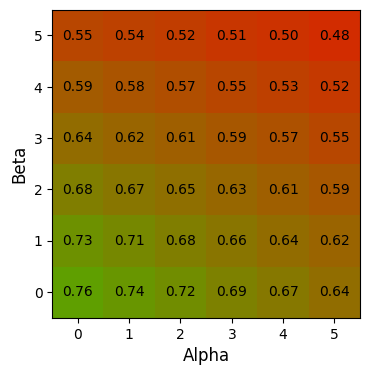

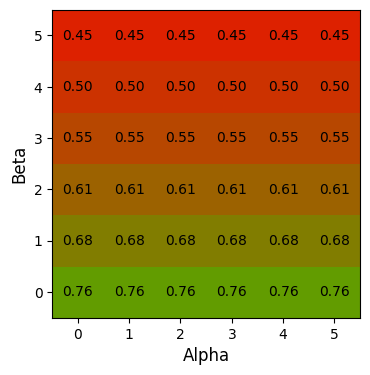

In [5]:
out_results = np.zeros((len(all_alpha), len(all_beta)))

for series_ind in [0,1]:
    struct_ind = 0
    for a,b in OAR_results[list(all_study_results.keys())[series_ind]]['weighted'].keys():
        out_results[a][b] = list(OAR_results[list(all_study_results.keys())[series_ind]]['weighted'][(a,b)].values())[struct_ind]

    plt.figure(figsize=(4,4))
    plt.imshow(
        out_results.T, vmin=0, vmax=1, origin='lower',
        cmap=colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=plt.get_cmap('brg').name, a=0.45, b=1),
            plt.get_cmap('brg')(np.linspace(0.2, 1, 100))
        )
    )
    for a in range(out_results.shape[0]):
        for b in range(out_results.shape[1]):
            plt.text(all_alpha[a], all_beta[b], f'{out_results[a][b]:.2f}', ha='center', va='center')
    plt.xlabel('Alpha', fontsize=12)
    plt.ylabel('Beta', fontsize=12)
    # plt.colorbar()
    # plt.title('Left Case' if series_ind == 0 else 'Right Case')
    plt.show()

In [ ]:
study_num = '630'

plt.figure(figsize=(6,6))
unweighted_array = np.array(len(all_alpha)*[OAR_results[study_num]['unweighted']])
plt.plot(all_alpha, unweighted_array, linestyle='-', color='k', label='Unweighted DSC')
plt.plot(all_alpha, OAR_results[study_num]['weighted'][:,0], linestyle='-', color='r', label='Weighted DSC (Left Parotid)')
plt.plot(all_alpha, OAR_results[study_num]['weighted'][:,1], linestyle='--', color='r', label='Weighted DSC (Right Parotid)')
# TODO: weighted by number of voxels? for 3D?
plt.plot(all_alpha, np.mean(OAR_results[study_num]['weighted'],axis=1), linestyle='-', color='g', label='Weighted DSC (Combined)')
plt.ylim([0,1])
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel('DSC', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
plt.legend(fontsize=10, loc='lower left')
plt.show()

# Ways to weight the voxels
### 1. Based on QUANTEC data (differentiate between dmean and dmax?)
### 2. Based on NTCP models if voxel dose is input into the NTCP model for the OAR
### 3. Based on dose of each voxel, similar to "Application of a weighted Dice Similarity Coefficient (DSC) for Structure Comparison in Radiation Treatment Planning" by Zachary Fried